# Configure Preprocessing Params

This notebook should be used to set up preprocessing params.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## Imports

In [9]:
from pathlib import Path
import yaml
import pandas as pd
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_samples_df,
    create_micropanel,
)
from lib.preprocess.preprocess import extract_metadata, convert_to_array
from lib.preprocess.file_utils import get_sample_fps

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for preprocessing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing*.
- `ROOT_FP`: Path to root of Brieflow output directory*.

*Note: Paths can be absolute or relative to where workflows are run from.

In [10]:
CONFIG_FILE_PATH = "config/config.yml"
ROOT_FP = "brieflow_output/"

Path(CONFIG_FILE_PATH).parent.mkdir(parents=True, exist_ok=True)
Path(ROOT_FP).mkdir(parents=True, exist_ok=True)

## <font color='red'>SET PARAMETERS</font>

### Paths to dataframes with sample information

- `SBS_SAMPLES_DF_FP`/`PHENOTYPE_SAMPLES_DF_FP`: Path to dataframe where SBS/phenotype samples location and metadata will be stored.
- `SBS_COMBO_DF_FP`/`PHENOTYPE_COMBO_DF_FP`: Path to dataframe where SBS/phenotype sample metadata combinations will be stored.
- `SBS_IMAGES_DIR_FP`/`PHENOTYPE_IMAGES_DIR_FP`: Path to directories with SBS/phenotype sample nd2 files. Set to `None` to ignore SBS/phenotype testing in this notebook.

### Pattern configurations for metadata extraction

#### SBS Configuration
- `SBS_PATH_PATTERN`: Regex pattern to match directory structure of SBS files
- `SBS_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile, "cycle""` to extract SBS processing information
- `SBS_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

#### Phenotype Configuration
- `PHENOTYPE_PATH_PATTERN`: Regex pattern to match directory structure of phenotype files  
- `PHENOTYPE_PATH_METADATA`: List of metadata to extract from file path
    - Should include at least `"plate", "well", "tile"` to extract phentoype processing information
- `PHENOTYPE_METADATA_ORDER_TYPE`: Metadata order will be used to organize the file paths dataframe. Metadata types will be used to convert parsed information.

*Notes:*
- Paths can be absolute or relative to where workflows are run from
- Each pattern (path and sample) should have the same number of capture groups as pieces of metadata listed
- Metadata lists should be ordered to match the capture groups in their corresponding regex pattern
- For both path and sample patterns, numeric values (like cycle numbers) will automatically be converted to integers
- For Brieflow to run effectively, each sample fil epath should have an associated plate/well. For single plate/well screens manually add a plate/well to the file path dataframe.

In [11]:
# paths to sample dataframes
SBS_SAMPLES_DF_FP = "config/sbs_samples.tsv"
PHENOTYPE_SAMPLES_DF_FP = "config/phenotype_samples.tsv"

# paths to combination dataframes
SBS_COMBO_DF_FP = "config/sbs_combo.tsv"
PHENOTYPE_COMBO_DF_FP = "config/phenotype_combo.tsv"

SBS_DATA_FORMAT = "tiff"  
SBS_DATA_ORGANIZATION = "tile"
SBS_IMAGES_DIR_FP = Path("/lab/ops_data/pumori/input_sbs/")  

SBS_PATH_PATTERN = r"plate_(\d+)/C(\d+)/([A-Z]\d+)_(\d+)_0_Fluorescence_(\d+_nm_Ex(?:_-_\d+)?).tiff"
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile", "channel"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int, "channel": str}

PHENOTYPE_DATA_FORMAT = "nd2"
PHENOTYPE_DATA_ORGANIZATION = "tile"
PHENOTYPE_IMAGES_DIR_FP = Path("/lab/ops_data/pumori/input_ph/")

PHENOTYPE_PATH_PATTERN = r"plate_(\d+)/round_(\d+)/Well([A-Z]\d+)_Point[A-Z]\d+_(\d+)_ChannelDAPI_Seq\d+\.nd2"
PHENOTYPE_PATH_METADATA = ["plate", "round", "well", "tile"]  
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "round": int, "well": str, "tile": int}

You must supply a working regex to the `SBS_PATH_PATTERN` and `PHENOTYPE_PATH_PATTERN` variables. If you don't have experience with regex, you can use the following LLM prompt to generate the patterns.

*Enter into a basic LLM chatbot*: 

Given ND2 filenames from your experiment, generate regex patterns to extract metadata. Return only the regex patterns with no explanation.

Example sbs filenames: **[ENTER YOUR EXAMPLE SBS FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Example phenotype filenames: **[ENTER YOUR EXAMPLE PHENOTYPE FILES HERE WITH ANY UPSTREAM FOLDER STRUCTURE THAT IS RELEVANT TO THE METADATA]**

Required regex patterns (return these exact variable assignments):
```python
SBS_PATH_PATTERN = r"..."      # To match file path structure
PHENOTYPE_PATH_PATTERN = r"..." # To match file path structure
```

The patterns should extract:
1. SBS pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")
     - Cycle number (after "/c")
2. PHENOTYPE pattern:
     - Plate number (after "plate_")
     - Well ID (e.g., "A1", "B2")
     - Tile number (after "Points-")

Also provide the corresponding metadata lists and variable types:
```python
SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

Example patterns for reference:
```python
SBS_PATH_PATTERN = r"plate_(\d+)/c(\d+)/.*_Wells-([A-Z]\d+)_Points-(\d+)__.*"
PHENOTYPE_PATH_PATTERN = r"P(\d+)_Pheno_20x_Wells-([A-Z]\d+)_Points-(\d+)__.*"

SBS_PATH_METADATA = ["plate", "cycle", "well", "tile"]
PHENOTYPE_PATH_METADATA = ["plate", "well", "tile"]

SBS_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int, "cycle": int}
PHENOTYPE_METADATA_ORDER_TYPE = {"plate": int, "well": str, "tile": int}
```

## Create Sample DFs

In [12]:
# Create SBS samples DataFrame (always)
sbs_samples = create_samples_df(
    SBS_IMAGES_DIR_FP, SBS_PATH_PATTERN, SBS_PATH_METADATA, SBS_METADATA_ORDER_TYPE
)
sbs_samples.to_csv(SBS_SAMPLES_DF_FP, sep="\t", index=False)
print("SBS samples:")
display(sbs_samples)

# Create SBS wildcard combos (only for tile organization)
if SBS_DATA_ORGANIZATION == "tile":
    sbs_wildcard_combos = sbs_samples[SBS_PATH_METADATA].drop_duplicates().astype(str)
    sbs_wildcard_combos.to_csv(SBS_COMBO_DF_FP, sep="\t", index=False)
    print("SBS wildcard combos:")
    display(sbs_wildcard_combos)
else:
    print("SBS: Using well organization - wildcard combos will be generated later")

# Create phenotype samples DataFrame (always)
phenotype_samples = create_samples_df(
    PHENOTYPE_IMAGES_DIR_FP,
    PHENOTYPE_PATH_PATTERN,
    PHENOTYPE_PATH_METADATA,
    PHENOTYPE_METADATA_ORDER_TYPE,
)
phenotype_samples.to_csv(PHENOTYPE_SAMPLES_DF_FP, sep="\t", index=False)
print("Phenotype samples:")
display(phenotype_samples)

# Create phenotype wildcard combos (only for tile organization)
if PHENOTYPE_DATA_ORGANIZATION == "tile":
    phenotype_wildcard_combos = phenotype_samples[PHENOTYPE_PATH_METADATA].drop_duplicates().astype(str)
    phenotype_wildcard_combos.to_csv(PHENOTYPE_COMBO_DF_FP, sep="\t", index=False)
    print("Phenotype wildcard combos:")
    display(phenotype_wildcard_combos)
else:
    print("Phenotype: Using well organization - wildcard combos will be generated later")

SBS samples:


,sample_fp,plate,well,tile,cycle,channel
0,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,1,B1,0,1,405_nm_Ex
1,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,1,B1,0,1,561_nm_Ex_-_1
2,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,1,B1,0,1,561_nm_Ex_-_2
3,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,1,B1,0,1,638_nm_Ex_-_1
4,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,1,B1,0,1,638_nm_Ex_-_2
...,...,...,...,...,...,...
8155,/lab/ops_data/pumori/input_sbs/plate_1/C12/B2_...,1,B2,67,12,405_nm_Ex
8156,/lab/ops_data/pumori/input_sbs/plate_1/C12/B2_...,1,B2,67,12,561_nm_Ex_-_1
8157,/lab/ops_data/pumori/input_sbs/plate_1/C12/B2_...,1,B2,67,12,561_nm_Ex_-_2
8158,/lab/ops_data/pumori/input_sbs/plate_1/C12/B2_...,1,B2,67,12,638_nm_Ex_-_1


SBS wildcard combos:


,plate,cycle,well,tile,channel
0,1,1,B1,0,405_nm_Ex
1,1,1,B1,0,561_nm_Ex_-_1
2,1,1,B1,0,561_nm_Ex_-_2
3,1,1,B1,0,638_nm_Ex_-_1
4,1,1,B1,0,638_nm_Ex_-_2
...,...,...,...,...,...
8155,1,12,B2,67,405_nm_Ex
8156,1,12,B2,67,561_nm_Ex_-_1
8157,1,12,B2,67,561_nm_Ex_-_2
8158,1,12,B2,67,638_nm_Ex_-_1


Phenotype samples:


,sample_fp,plate,round,well,tile
0,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B1,0
1,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B1,1
2,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B1,2
3,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B1,3
4,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B1,4
...,...,...,...,...,...
2723,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B2,1359
2724,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B2,1360
2725,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B2,1361
2726,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,B2,1362


Phenotype wildcard combos:


,plate,round,well,tile
0,1,1,B1,0
1,1,1,B1,1
2,1,1,B1,2
3,1,1,B1,3
4,1,1,B1,4
...,...,...,...,...
2723,1,1,B2,1359
2724,1,1,B2,1360
2725,1,1,B2,1361
2726,1,1,B2,1362


## <font color='red'>SET PARAMETERS</font>

### Metadata Source Configuration

- `SBS_METADATA_*`/`PHENOTYPE_METADATA_*`: Configuration for external metadata files containing positional and imaging metadata.
 - **For TIFF files**: Usually required (e.g., `coordinates.csv`, `metadata.tsv`)
 - **For ND2 files**: Usually set directories to `None` (metadata extracted from ND2 headers)
 - **For OME-Zarr files**: Usually set directories to `None` (metadata in OME metadata)

**Metadata File Organization:**
- `*_METADATA_IMAGES_DIR_FP`: Base directory containing metadata files
- `*_METADATA_PATH_PATTERN`: Regex pattern to find metadata files
- `*_METADATA_PATH_METADATA`: Metadata to extract from file paths
- `*_METADATA_SAMPLES_DF_FP`: Where to save the metadata file inventory

In [13]:
# Set metadata extraction parameters
SBS_METADATA_IMAGES_DIR_FP = Path("/lab/ops_data/pumori/input_sbs/")
SBS_METADATA_PATH_PATTERN = r"plate_(\d+)/C(\d+)/coordinates\.csv"
SBS_METADATA_PATH_METADATA = ["plate", "cycle"]
SBS_METADATA_ORDER_TYPE = {"plate": int, "cycle": int}
SBS_METADATA_SAMPLES_DF_FP = "config/sbs_metadata_samples.tsv"

PHENOTYPE_METADATA_IMAGES_DIR_FP = None
PHENOTYPE_METADATA_PATH_PATTERN = None
PHENOTYPE_METADATA_PATH_METADATA = None
PHENOTYPE_METADATA_ORDER_TYPE = None
PHENOTYPE_METADATA_SAMPLES_DF_FP = None

In [14]:
# Generate SBS metadata samples table
if SBS_METADATA_IMAGES_DIR_FP is not None:
    print("Generating SBS metadata file inventory...")
    sbs_metadata_samples = create_samples_df(
        SBS_METADATA_IMAGES_DIR_FP, 
        SBS_METADATA_PATH_PATTERN, 
        SBS_METADATA_PATH_METADATA, 
        SBS_METADATA_ORDER_TYPE
    )
    sbs_metadata_samples.to_csv(SBS_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("SBS metadata files found:")
    display(sbs_metadata_samples)
else:
    print("SBS: No external metadata files - will extract from image files")
    sbs_metadata_samples = pd.DataFrame()

# Generate phenotype metadata samples table
if PHENOTYPE_METADATA_IMAGES_DIR_FP is not None:
    print("\nGenerating phenotype metadata file inventory...")
    phenotype_metadata_samples = create_samples_df(
        PHENOTYPE_METADATA_IMAGES_DIR_FP,
        PHENOTYPE_METADATA_PATH_PATTERN,
        PHENOTYPE_METADATA_PATH_METADATA,
        PHENOTYPE_METADATA_ORDER_TYPE
    )
    phenotype_metadata_samples.to_csv(PHENOTYPE_METADATA_SAMPLES_DF_FP, sep="\t", index=False)
    print("Phenotype metadata files found:")
    display(phenotype_metadata_samples)
else:
    print("Phenotype: No external metadata files - will extract from ND2 files")
    phenotype_metadata_samples = pd.DataFrame()

Generating SBS metadata file inventory...
SBS metadata files found:


,sample_fp,plate,cycle
0,/lab/ops_data/pumori/input_sbs/plate_1/C1/coor...,1,1
1,/lab/ops_data/pumori/input_sbs/plate_1/C2/coor...,1,2
2,/lab/ops_data/pumori/input_sbs/plate_1/C3/coor...,1,3
3,/lab/ops_data/pumori/input_sbs/plate_1/C4/coor...,1,4
4,/lab/ops_data/pumori/input_sbs/plate_1/C5/coor...,1,5
5,/lab/ops_data/pumori/input_sbs/plate_1/C6/coor...,1,6
6,/lab/ops_data/pumori/input_sbs/plate_1/C7/coor...,1,7
7,/lab/ops_data/pumori/input_sbs/plate_1/C8/coor...,1,8
8,/lab/ops_data/pumori/input_sbs/plate_1/C9/coor...,1,9
9,/lab/ops_data/pumori/input_sbs/plate_1/C10/coo...,1,10


Phenotype: No external metadata files - will extract from ND2 files


## Test Metadata Extraction

In [15]:
if len(sbs_samples) > 0:
    print("Testing SBS metadata extraction...")
    
    # Get metadata file for this specific sample
    if len(sbs_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            sbs_metadata_samples,
            plate=sbs_samples["plate"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  # <-- FIX: Define the variable here too
        print("No metadata files - extracting from image files")
    
    # Extract metadata using unified function
    test_sbs_metadata = extract_metadata(
        sbs_samples["sample_fp"].iloc[0],
        plate=sbs_samples["plate"].iloc[0],
        well=sbs_samples["well"].iloc[0],
        tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
        cycle=sbs_samples.get("cycle", [None]).iloc[0],
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("SBS test metadata:")
    display(test_sbs_metadata)

# Test phenotype metadata extraction  
if len(phenotype_samples) > 0:
    print("\nTesting phenotype metadata extraction...")
    
    # Get metadata file for this specific sample (if any)
    if len(phenotype_metadata_samples) > 0:
        # Find matching metadata file
        test_metadata_file = get_sample_fps(
            phenotype_metadata_samples,
            plate=phenotype_samples["plate"].iloc[0],
            round=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None
        )
        print(f"Using metadata file: {test_metadata_file}")
    else:
        test_metadata_file = None  # <-- FIX: Define the variable here too
        print("No metadata files - extracting from ND2 files")
    
    # Extract metadata using unified function
    test_phenotype_metadata = extract_metadata(
        phenotype_samples["sample_fp"].iloc[0],
        plate=phenotype_samples["plate"].iloc[0],
        well=phenotype_samples["well"].iloc[0],
        tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
        round=phenotype_samples["round"].iloc[0] if "round" in phenotype_samples.columns else None,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        metadata_file_path=test_metadata_file,
        verbose=True
    )
    print("Phenotype test metadata:")
    display(test_phenotype_metadata)

Testing SBS metadata extraction...
Using metadata file: /lab/ops_data/pumori/input_sbs/plate_1/C1/coordinates.csv
Reading metadata from: /lab/ops_data/pumori/input_sbs/plate_1/C1/coordinates.csv
Columns: ['region', 'fov', 'z_level', 'x (mm)', 'y (mm)', 'z (um)', 'time']
Converted 136 rows of metadata
SBS test metadata:


,plate,well,tile,filename,x_pos,y_pos,z_pos,pfs_offset,channels,pixel_size_x,pixel_size_y,cycle
0,1,B1,0,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,20196.17500,45513.62500,3317.34375,None,None,None,None,1
1,1,B1,1,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,23722.80625,45513.62500,3319.12500,None,None,None,None,1
2,1,B1,2,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,13143.70625,49040.25625,3315.18750,None,None,None,None,1
3,1,B1,3,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,16670.33750,49040.25625,3315.00000,None,None,None,None,1
4,1,B1,4,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,20196.17500,49040.25625,3316.87500,None,None,None,None,1
...,...,...,...,...,...,...,...,...,...,...,...,...
131,1,B2,63,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,62922.15000,73722.70625,3277.12500,None,None,None,None,1
132,1,B2,64,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,66448.78125,73722.70625,3274.50000,None,None,None,None,1
133,1,B2,65,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,69974.61875,73722.70625,3270.65625,None,None,None,None,1
134,1,B2,66,/lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0...,59396.31250,77249.33750,3280.59375,None,None,None,None,1



Testing phenotype metadata extraction...
No metadata files - extracting from ND2 files
Processing tile 0 from file /lab/ops_data/pumori/input_ph/plate_1/round_1/WellB1_PointB1_0000_ChannelDAPI_Seq0000.nd2
File shape: (3, 1480, 1480)
Number of dimensions: 3
Data type: uint16
Sizes (by axes): {'Z': 3, 'Y': 1480, 'X': 1480}
Phenotype test metadata:


,x_pos,y_pos,z_pos,pfs_offset,plate,well,tile,filename,channels,round,pixel_size_x,pixel_size_y
0,41334.4,3290.9,2840.16,None,1,B1,0,/lab/ops_data/pumori/input_ph/plate_1/round_1/...,1,1,0.607143,0.607143


## <font color='red'>SET PARAMETERS</font>

### ND2 conversion

- `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER`: Manually set channel order _if ND2 images are acquired as single channels, or there are multiple files for each tile (e.g. multiple rounds of phenotype images). Should be `None` if multichannel image files are acquired. The extracted channel names must match the values that will be displayed in the samples DataFrame channel column (e.g., `["DAPI", "GFP", "CY3", "CY5", "AF750"]`).
- `PHENOTYPE_ROUND_ORDER`: List of round numbers specifying the order in which to process phenotype image rounds. Should be `None` if there is only one round of phenotyping. For multiple rounds, specify the round numbers in the desired order (e.g., `[1, 2, 3]`). The round numbers must match the values in the samples DataFrame round column.

**Note** For single-channel files, each file must contain a channel identifier that your regex can extract. For multichannel files, set the channel patterns to `None`. Metadata extraction is only performed on the first channel dimension for each tile. Please ensure the Dapi channel is displayed first!

- `SBS_CHANNEL_ORDER_FLIP`/`PHENOTYPE_CHANNEL_ORDER_FLIP`: Whether or not to flip channel order when converting ND2->tiff. Should be `False` if channels are in a standard order (with Dapi first), or `True` if channels are reversed. This will only occur for multichannel ND2 files, for each individual ND2 file. Setting the channel order for single channel files is done by setting `SBS_CHANNEL_ORDER`/`PHENOTYPE_CHANNEL_ORDER` previously.

**Note** Channel order can be checked with the test conversions below. Please ensure the Dapi channel is displayed first!

In [16]:
SBS_CHANNEL_ORDER = ["405_nm_Ex", "561_nm_Ex_-_1", "561_nm_Ex_-_2", "638_nm_Ex_-_1", "638_nm_Ex_-_2"]
PHENOTYPE_CHANNEL_ORDER = None
PHENOTYPE_ROUND_ORDER = [1]

In [17]:
SBS_CHANNEL_ORDER_FLIP = False
PHENOTYPE_CHANNEL_ORDER_FLIP = False

## Test ND2 Conversion

### Test SBS conversion

Testing SBS image conversion...
Processing TIFF file 1/5: /lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0_0_Fluorescence_405_nm_Ex.tiff


TIFF array shape: (1, 2084, 2084)
Processing TIFF file 2/5: /lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0_0_Fluorescence_561_nm_Ex_-_1.tiff
TIFF array shape: (1, 2084, 2084)
Processing TIFF file 3/5: /lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0_0_Fluorescence_561_nm_Ex_-_2.tiff
TIFF array shape: (1, 2084, 2084)
Processing TIFF file 4/5: /lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0_0_Fluorescence_638_nm_Ex_-_1.tiff
TIFF array shape: (1, 2084, 2084)
Processing TIFF file 5/5: /lab/ops_data/pumori/input_sbs/plate_1/C1/B1_0_0_Fluorescence_638_nm_Ex_-_2.tiff
TIFF array shape: (1, 2084, 2084)
SBS converted image shape: (5, 2084, 2084)


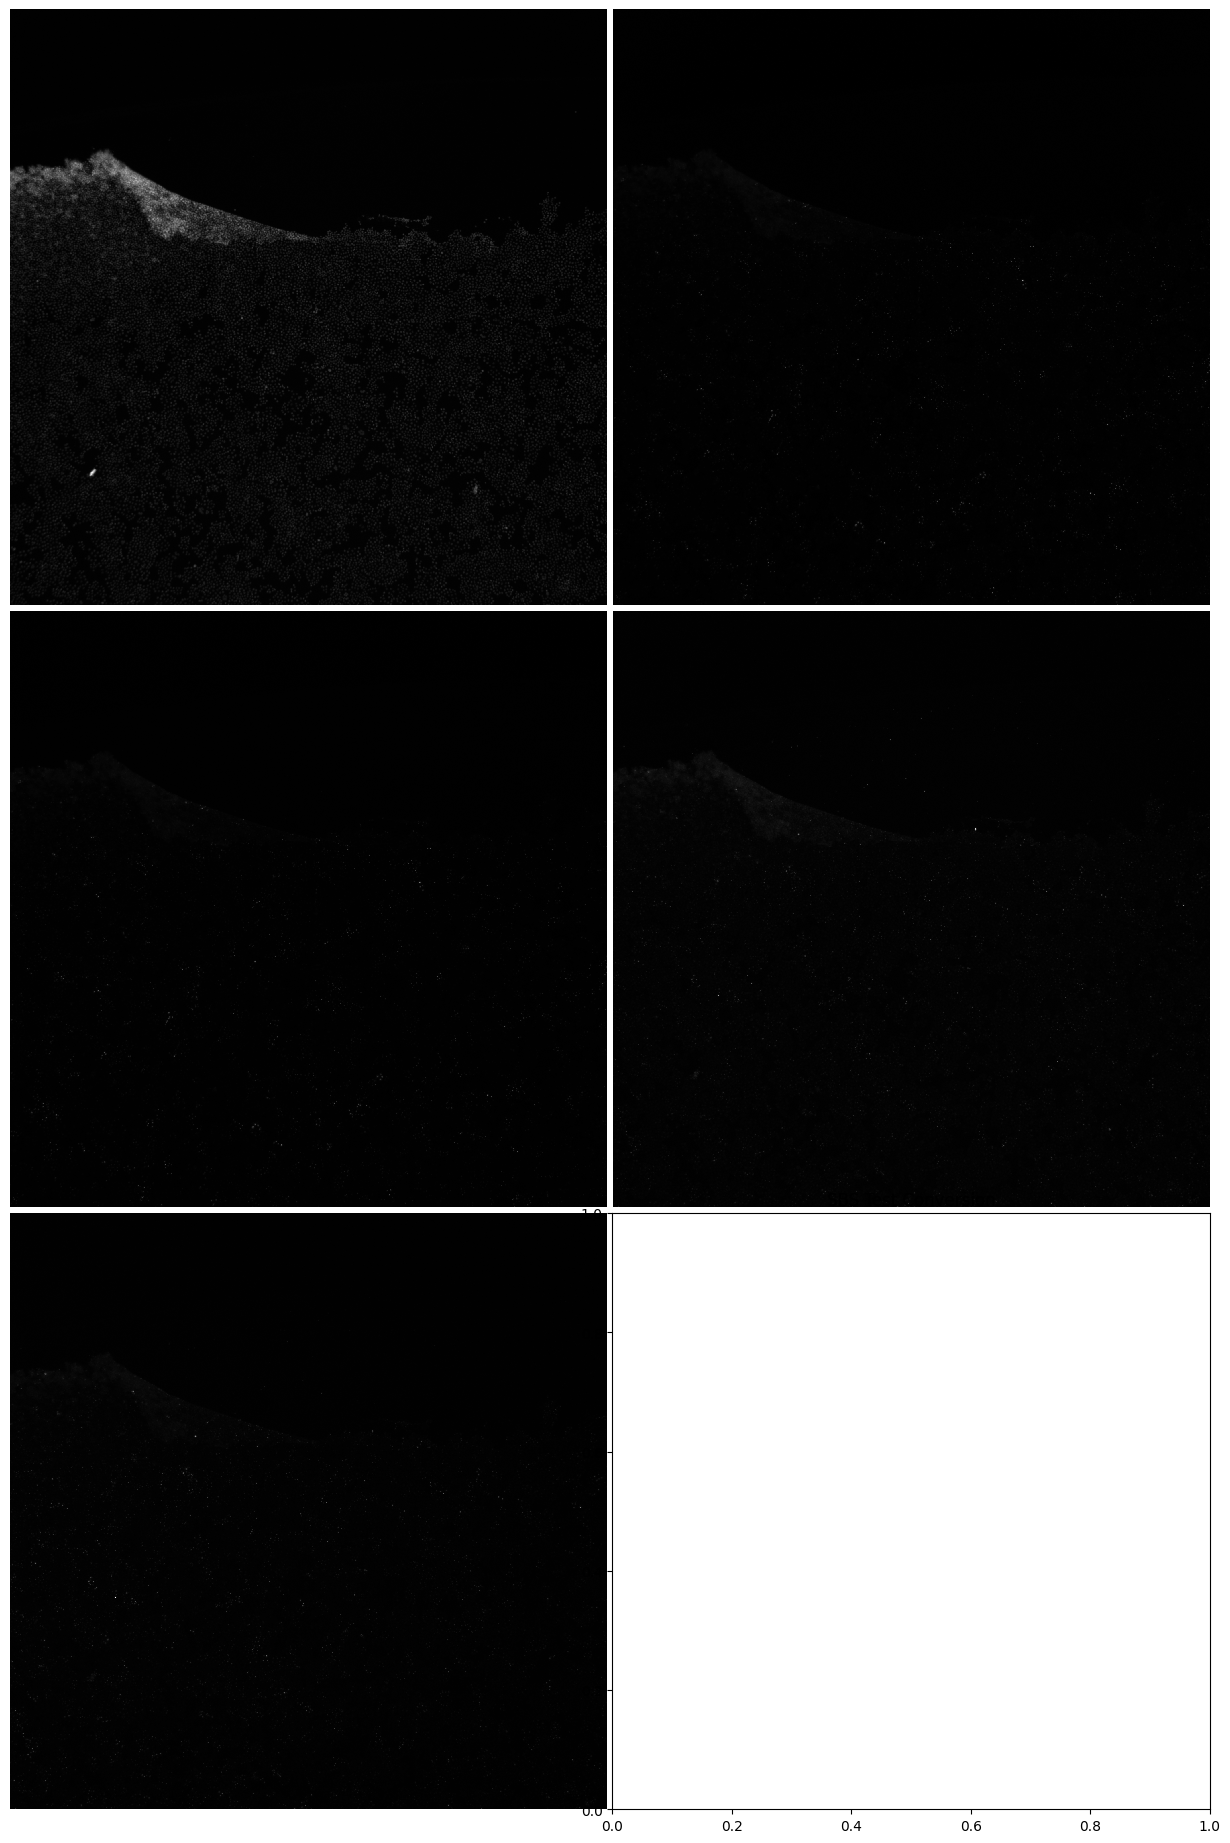

In [18]:
if len(sbs_samples) > 0:
    print("Testing SBS image conversion...")
    
    # Get sample files based on data organization
    if SBS_DATA_ORGANIZATION == "tile":
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            tile=sbs_samples["tile"].iloc[0] if "tile" in sbs_samples.columns else 0,
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
    else:  # well organization
        sbs_sample_files = get_sample_fps(
            sbs_samples,
            plate=sbs_samples["plate"].iloc[0],
            well=sbs_samples["well"].iloc[0],
            cycle=sbs_samples["cycle"].iloc[0] if "cycle" in sbs_samples.columns else None,
            channel_order=SBS_CHANNEL_ORDER,
        )
        
    # Convert using unified function
    sbs_image = convert_to_array(
        sbs_sample_files,
        data_format=SBS_DATA_FORMAT,
        data_organization=SBS_DATA_ORGANIZATION,
        position=0 if SBS_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=SBS_CHANNEL_ORDER_FLIP,
        verbose=True
    )
    
    print(f"SBS converted image shape: {sbs_image.shape}")
    
    # Display images
    sbs_microimages = [Microimage(image) for image in sbs_image]
    sbs_panel = create_micropanel(sbs_microimages, add_channel_label=False)
    plt.title("SBS Test Conversion")
    plt.show()

### Test phenotype conversion

Testing phenotype image conversion...
Processing file 1/1: /lab/ops_data/pumori/input_ph/plate_1/round_1/WellB1_PointB1_0000_ChannelDAPI_Seq0000.nd2
Original dimensions for /lab/ops_data/pumori/input_ph/plate_1/round_1/WellB1_PointB1_0000_ChannelDAPI_Seq0000.nd2: ('Z', 'Y', 'X')
Array shape after processing: (1, 1480, 1480)
Final dimensions (CYX): (1, 1480, 1480)
Phenotype converted image shape: (1, 1480, 1480)


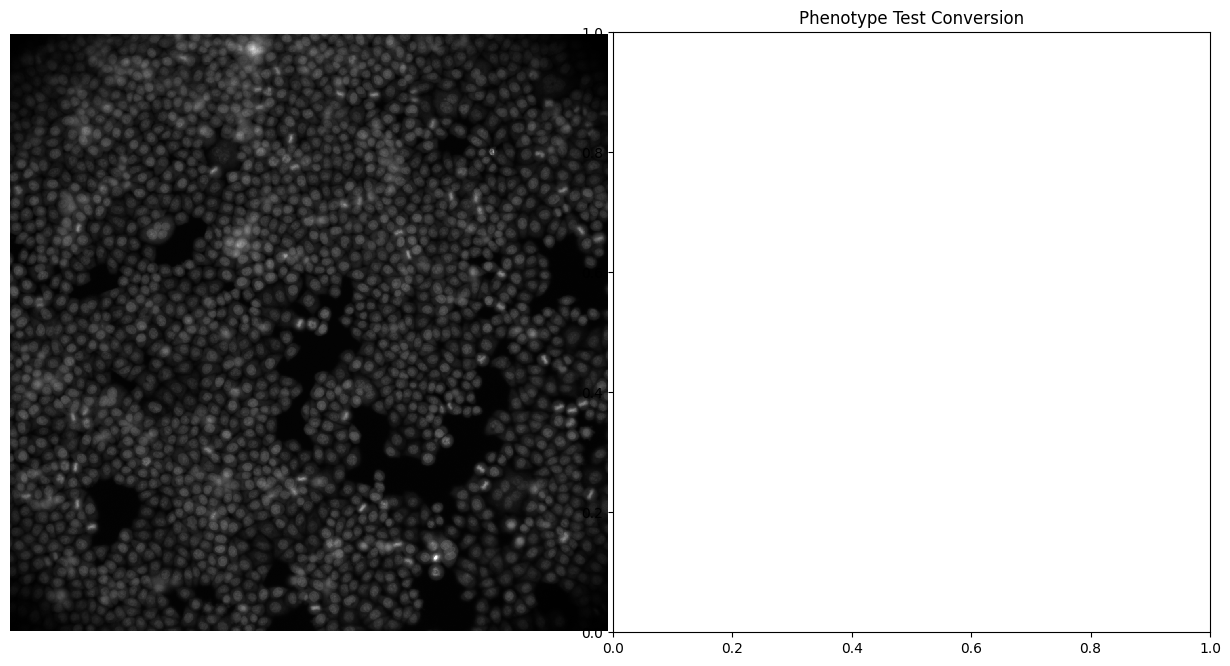

In [19]:
if len(phenotype_samples) > 0:
    print("Testing phenotype image conversion...")
    
    # Get sample files based on data organization
    if PHENOTYPE_DATA_ORGANIZATION == "tile":
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            tile=phenotype_samples["tile"].iloc[0] if "tile" in phenotype_samples.columns else 0,
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
    else:  # well organization
        phenotype_sample_files = get_sample_fps(
            phenotype_samples,
            plate=phenotype_samples["plate"].iloc[0],
            well=phenotype_samples["well"].iloc[0],
            round_order=PHENOTYPE_ROUND_ORDER,
            channel_order=PHENOTYPE_CHANNEL_ORDER,
        )
      
    # Convert using unified function
    phenotype_image = convert_to_array(
        phenotype_sample_files,
        data_format=PHENOTYPE_DATA_FORMAT,
        data_organization=PHENOTYPE_DATA_ORGANIZATION,
        position=0 if PHENOTYPE_DATA_ORGANIZATION == "well" else None,
        channel_order_flip=PHENOTYPE_CHANNEL_ORDER_FLIP,
        verbose=True
    )
    
    print(f"Phenotype converted image shape: {phenotype_image.shape}")
    
    # Display images
    phenotype_microimages = [Microimage(image) for image in phenotype_image]
    phenotype_panel = create_micropanel(phenotype_microimages, add_channel_label=False)
    plt.title("Phenotype Test Conversion")
    plt.show()

## <font color='red'>SET PARAMETERS</font>

### Calculate illumination correction field

- `SAMPLE_FRACTION`: Controls what percentage of images to use when calculating the illumination correction field (0.0-1.0). Using a smaller fraction (e.g., 0.2 = 20%) speeds up processing by randomly sampling only a subset of your images. Default is 1.0 (use all images). For reliable results, ensure your sample contains enough images to accurately represent illumination variation.

In [12]:
SAMPLE_FRACTION = 0.5

## Create config file with params

In [ ]:
# Create empty config variable
config = {}

# Add all section
config["all"] = {
    "root_fp": ROOT_FP,
}

# Add preprocess section
config["preprocess"] = {
    # File paths
    "sbs_samples_fp": SBS_SAMPLES_DF_FP,
    "sbs_combo_fp": SBS_COMBO_DF_FP,
    "phenotype_samples_fp": PHENOTYPE_SAMPLES_DF_FP,
    "phenotype_combo_fp": PHENOTYPE_COMBO_DF_FP,
    
    # SBS configuration
    "sbs_data_format": SBS_DATA_FORMAT,
    "sbs_data_organization": SBS_DATA_ORGANIZATION,
    "sbs_channel_order": SBS_CHANNEL_ORDER,
    "sbs_channel_order_flip": SBS_CHANNEL_ORDER_FLIP,
    "sbs_metadata_samples_df_fp": SBS_METADATA_SAMPLES_DF_FP,
    
    # Phenotype configuration
    "phenotype_data_format": PHENOTYPE_DATA_FORMAT,
    "phenotype_data_organization": PHENOTYPE_DATA_ORGANIZATION,
    "phenotype_channel_order": PHENOTYPE_CHANNEL_ORDER,
    "phenotype_channel_order_flip": PHENOTYPE_CHANNEL_ORDER_FLIP,
    "phenotype_round_order": PHENOTYPE_ROUND_ORDER,
    "phenotype_metadata_samples_df_fp": PHENOTYPE_METADATA_SAMPLES_DF_FP,

    # Processing parameters
    "sample_fraction": SAMPLE_FRACTION,
}

# Write the updated configuration back with markdown-style comments
with open(CONFIG_FILE_PATH, "w") as config_file:
    # Write the introductory markdown-style comments
    config_file.write(CONFIG_FILE_HEADER)

    # Dump the updated YAML structure, keeping markdown comments for sections
    yaml.dump(config, config_file, default_flow_style=False, sort_keys=False)